In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import cm
from IPython.html.widgets import interact
import pickle

from dataset_mgmt import *
from nnet_core import *
from transfer_funcs import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [17]:
dataset = pickle.load(open('single_layer.json', 'rb'))

data_names = ('Net Quantity', 'Net Keep Qty', 'Learning Rate', 'Weight Decay Rate',  
         'First Layer Nodes', 'Second Layer Nodes', 'Learning Epochs', 
         'Training Set Size', 'Training Batch Size', 'Effectiveness')

for name in data_names:
    dataset[name] = [x for y,x in sorted(zip(dataset['Effectiveness'], dataset[name]))[::-1]]

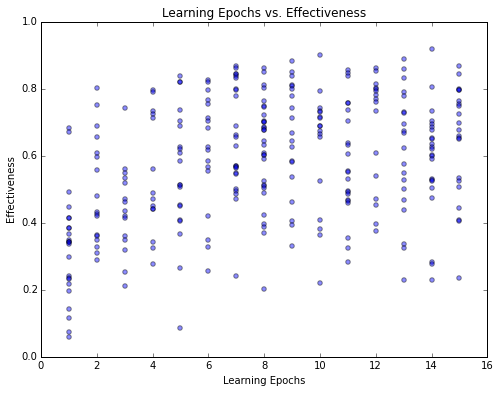

In [3]:
def create_plot(dataname):
    plt.scatter(dataset[dataname], dataset['Effectiveness'], alpha=0.45)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel(dataname)
    plt.ylabel('Effectiveness')
    plt.title(dataname + ' vs. Effectiveness')
    
interact(create_plot, dataname=data_names)

11 11 [ 0.      0.0001  0.0002  0.0003  0.0004  0.0005  0.0006  0.0007  0.0008
  0.0009  0.001 ]


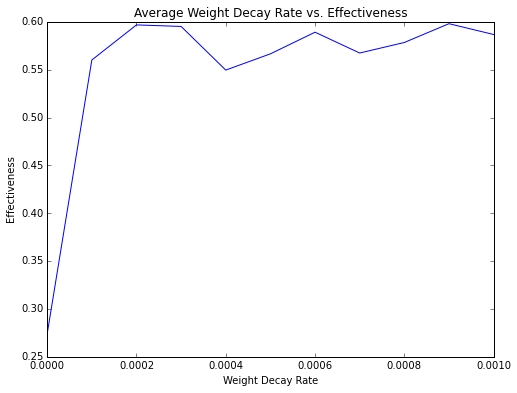

In [16]:
def create_avg_plot(dataname, smoothing=2):
    data = dataset[dataname]
    eff = dataset['Effectiveness']
    boxes = []
    if type(min(data)) == float: 
        if dataname == 'Learning Rate': boxes = np.linspace(5, 15, 11) * 0.1
        if dataname == 'Weight Decay Rate': boxes = np.linspace(0, 0.0010, 11)
    else: boxes = np.linspace(min(data), max(data), max(data) - min(data) + 1)
    
    new_boxes = []
    new_eff = []
    for i in boxes:
        tmp = [y for x, y in zip(data, eff) if x == i]
        if len(tmp) == 0: continue
        new_eff.append(sum(tmp) / float(len(tmp)))
        new_boxes.append(i)
    
    if len(new_eff) == 0: return
    
    print(len(boxes), len(new_eff), boxes)
    
    new_eff_smooth = np.convolve(new_eff, np.ones(smoothing)/float(smoothing), 'same')

    plt.plot(new_boxes, new_eff_smooth)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel(dataname)
    plt.ylabel('Effectiveness')
    plt.title('Average ' + dataname + ' vs. Effectiveness')
    
interact(create_avg_plot, dataname=data_names, smoothing=(1, 10, 1))

In [5]:
def best_setup(count):
    for name in data_names:
        print(name + ": ", float(sum(dataset[name][0:count]))/float(count))
        
interact(best_setup, count=(1, len(dataset['Effectiveness'])))

Net Quantity:  11.555555555555555
Net Keep Qty:  8.055555555555555
Learning Rate:  0.9166666666666666
Weight Decay Rate:  0.00040555555555555554
First Layer Nodes:  22.944444444444443
Second Layer Nodes:  0.0
Learning Epochs:  10.444444444444445
Training Set Size:  790.0
Training Batch Size:  2.7777777777777777
Effectiveness:  0.8653333333333333
